# Feature Analysis

**RankEval** provides feature analysis tools that allow to estimate the **feature importance** of a trained tree-based ensemble. This analysis can be used for feature selection to improve the estimators’ efficiency on very high-dimensional datasets. The general premise is that features can be either irrelevant or redundant, and thus they can be removed from the dataset without incurring in much loss of information.

A benefit of using gradient boosting algorithms consisting of a number of binary decision trees is that it is relatively straightforward to compute feature importance scores at training time. Indeed, each decision tree is described by multiple nodes, either split or leaf nodes. Every split node is a condition on a single feature, and it is designed to split the dataset into two so that similar response values end up in the same set. Computing feature importance is thus as simple as to sum for each decision tree the amount that each split node (i.e., the feature used by the split node) improves a given performance measure. The performance measure most commonly adopted is the Gini index (purity) used to select the next split nodes at training time.

RankEval implement the calculation of feature importance by *simulating* the traditional training behaviour at scoring time, i.e., with the model already fully trained. To this regard RankEval allows to compute feature importance independently of the framework used to train the model, providing insightful also for frameworks that do not support feature analysis. Moreover, the calculation of feature importance is parametric in the performance measure, allowing for fine-grained and personalized analysis.

In [1]:
from __future__ import print_function

# set package autoreload and inline plot

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Import RankEval statistical significance tools

In [2]:
# import libraries
import numpy as np

from rankeval.model import RTEnsemble
from rankeval.dataset import Dataset
from rankeval.analysis.feature import feature_importance
from rankeval.visualization.feature import plot_feature_importance
from rankeval.dataset.datasets_fetcher import load_dataset

## Load Dataset using the `load_dataset` feature

In [3]:
# Dataset container
dataset_container = load_dataset(dataset_name='msn10k', 
                                 fold='1', 
                                 download_if_missing=True, 
                                 force_download=False, 
                                 with_models=False)

Loading files. This may take a few minutes.
done loading dataset!


In [4]:
# Remapping Datasets Names
msn_train = dataset_container.train_dataset
msn_validation = dataset_container.validation_dataset
msn_test = dataset_container.test_dataset

## Train LightGBM model with All Features

Create a metric for computing the performance of the model

In [5]:
from rankeval.metrics import NDCG

ndcg_10 = NDCG(cutoff=10, no_relevant_results=0.5, implementation='exp')

In [6]:
import lightgbm
import os

def lightGBM_algo(trees, leaves, train_dataset, vali_dataset):

    lgbm_train_dataset = lightgbm.Dataset(data=train_dataset.X, label=train_dataset.y, group=train_dataset.get_query_sizes())
    lgbm_vali_dataset = lightgbm.Dataset(data=vali_dataset.X, label=vali_dataset.y, group=vali_dataset.get_query_sizes())
    
    # specify parameters via map    
    params = {
        'boosting_type': 'gbdt',
        'objective': 'lambdarank',
        'max_position': 10,
        'metric': ['ndcg'],
        'ndcg_at': [10],
        'num_leaves': leaves,
        'learning_rate': 0.05,
        'verbose': 1,
        'use_missing': False
    }

    lgbm_model = lightgbm.train(
        params, 
        lgbm_train_dataset, 
        num_boost_round=trees,
        valid_sets=[lgbm_train_dataset, lgbm_vali_dataset],
        valid_names=['train', 'vali'],
        early_stopping_rounds=100,
        verbose_eval=10
    )
    
    filename = 'lgbm.model'
    rankeval_model = None
    try:
        lgbm_model.save_model(filename=filename)
        rankeval_model = RTEnsemble(filename, 
                                    name="LightGBM model", 
                                    format="LightGBM")
    finally:
        os.remove(filename)
    
    return rankeval_model 

/usr/local/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Train LightGBM model with all features

In [16]:
msn_lgbm_lmart_1Ktrees_model = lightGBM_algo(trees=1000,
                                             leaves=64,
                                             train_dataset=msn_train,
                                             vali_dataset=msn_validation)

Training until validation scores don't improve for 100 rounds.
[10]	train's ndcg@10: 0.451019	vali's ndcg@10: 0.444563
[20]	train's ndcg@10: 0.464519	vali's ndcg@10: 0.451221
[30]	train's ndcg@10: 0.475353	vali's ndcg@10: 0.461042
[40]	train's ndcg@10: 0.481948	vali's ndcg@10: 0.465626
[50]	train's ndcg@10: 0.487324	vali's ndcg@10: 0.470402
[60]	train's ndcg@10: 0.491837	vali's ndcg@10: 0.475125
[70]	train's ndcg@10: 0.496397	vali's ndcg@10: 0.47756
[80]	train's ndcg@10: 0.500188	vali's ndcg@10: 0.481216
[90]	train's ndcg@10: 0.503707	vali's ndcg@10: 0.483867
[100]	train's ndcg@10: 0.507729	vali's ndcg@10: 0.487216
[110]	train's ndcg@10: 0.511066	vali's ndcg@10: 0.490838
[120]	train's ndcg@10: 0.514615	vali's ndcg@10: 0.491751
[130]	train's ndcg@10: 0.517417	vali's ndcg@10: 0.493754
[140]	train's ndcg@10: 0.519976	vali's ndcg@10: 0.495157
[150]	train's ndcg@10: 0.522037	vali's ndcg@10: 0.496316
[160]	train's ndcg@10: 0.524229	vali's ndcg@10: 0.49699
[170]	train's ndcg@10: 0.526593	vali

The training of the LightGBM model stopped at 756 trees, given that no further improvements were observed on the validation set in the following 100 iterations.

This model, that uses all the features, has a metric score of:

In [17]:
y_pred_train = msn_lgbm_lmart_1Ktrees_model.score(msn_train)
ndcg_10_mean_score, ndcg_10_query_scores = ndcg_10.eval(msn_train, y_pred_train)
print ("%s on Train: %.3f" % (ndcg_10, ndcg_10_mean_score))

y_pred_test = msn_lgbm_lmart_1Ktrees_model.score(msn_test)
ndcg_10_mean_score, ndcg_10_query_scores = ndcg_10.eval(msn_test, y_pred_test)
print ("%s on Test: %.3f" % (ndcg_10, ndcg_10_mean_score))

NDCG@10 on Train: 0.587
NDCG@10 on Test: 0.491


### Compute Feature Analysis

The `feature_importance` analysis is executed on a single dataset and model, using a given metric for computing the performance gain at each split node. By default the analysis uses MSE as performance measure (and only in this case the analysis is very efficient since it is realized using low-level cython code). The function returns a xarray.DataArray with the value of `feature_importance` and `feature_count` (the former summing performance gain related to a given feature, the latter counting the number of times a feature is used in a split node) for each feature.

In [18]:
from rankeval.analysis.feature import feature_importance
from rankeval.metrics import MSE

# Create the metric to use as performance measure
mse = MSE()

feature_analysis = feature_importance(model=msn_lgbm_lmart_1Ktrees_model, 
                                      dataset=msn_train, 
                                      metric=mse)
feature_analysis.T.to_dataframe()

Feature Importance Analysis
feature type                                   
0       importance                     0.000098
        count                         29.000000
1       importance                     0.000122
        count                         49.000000
2       importance                     0.000659
        count                        146.000000
3       importance                     0.000074
        count                         17.000000
4       importance                     0.000075
        count                         27.000000
5       importance                     0.000087
        count                         75.000000
6       importance                     0.000052
        count                         52.000000
7       importance                     0.000206
        count                        100.000000
8       importance                     0.000061
        count                         32.000000
9       importance                     0.000104
        count                         89.000000
10      importance                     0.002189
        count                       1077.000000
11      importance                     0.000644
        count                        424.000000
12      importance                     0.002369
        count                        769.000000
13      importance                     0.003120
        count                       1053.000000
14      importance                     0.006039
        count                        813.000000
...                                         ...
121     importance                     0.001107
        count                        483.000000
122     importance                     0.013610
        count                        532.000000
123     importance                     0.000920
        count                        390.000000
124     importance                     0.000699
        count                        303.000000
125     importance                     0.003039
        count                        939.000000
126     importance                     0.004164
        count                       1588.000000
127     importance                     0.002736
        count                       1174.000000
128     importance                     0.006204
        count                       1240.000000
129     importance                     0.006395
        count                       1970.000000
130     importance                     0.005311
        count                       2016.000000
131     importance                     0.002344
        count                       1142.000000
132     importance                     0.004909
        count                       1655.000000
133     importance                     0.021665
        count                        655.000000
134     importance                     0.003214
        count                        820.000000
135     importance                     0.001347
        count                        858.000000

[272 rows x 1 columns]

RankEval provides also a utility for directly plotting the result of the feature analysis in order to have a visual representation of the importance of each feature. The method `plot_feature_importance` takes in input the analysis executed above, as well as the number of top-k features to plot and how to sort the features (by importance gain or by gain). Moreover, it is possible to pass a list of feature names to use in place on feature index in the plot.

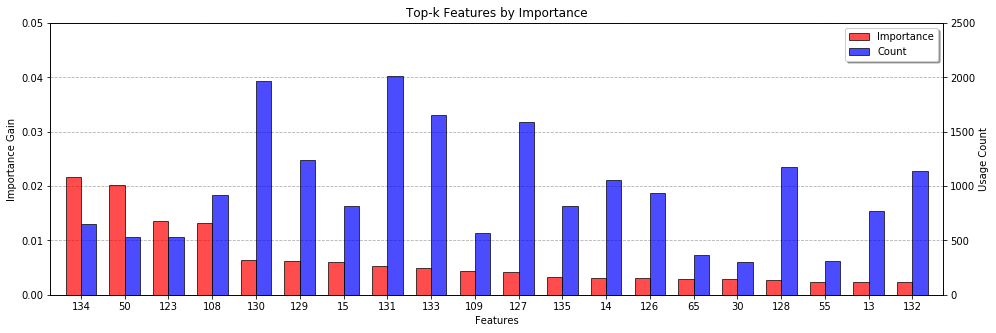

In [19]:
from rankeval.visualization.feature import plot_feature_importance

fig = plot_feature_importance(feature_analysis, max_features=20, sort_by='gain')

## Train LightGBM model by using only Top-20 Features out of 136

In [20]:
sorted_features = np.argsort(feature_analysis.sel(type='importance').values)[::-1]
top_features = sorted_features[:20]

msn_train_filtered = msn_train.subset_features(top_features)
msn_validation_filtered = msn_validation.subset_features(top_features)
msn_test_filtered = msn_test.subset_features(top_features)

msn_lgbm_lmart_1Ktrees_top20f_model = lightGBM_algo(trees=1000,
                                                    leaves=64,
                                                    train_dataset=msn_train_filtered,
                                                    vali_dataset=msn_validation_filtered)

Training until validation scores don't improve for 100 rounds.
[10]	train's ndcg@10: 0.449007	vali's ndcg@10: 0.44177
[20]	train's ndcg@10: 0.459094	vali's ndcg@10: 0.449289
[30]	train's ndcg@10: 0.467152	vali's ndcg@10: 0.456452
[40]	train's ndcg@10: 0.47287	vali's ndcg@10: 0.461863
[50]	train's ndcg@10: 0.478307	vali's ndcg@10: 0.465315
[60]	train's ndcg@10: 0.48325	vali's ndcg@10: 0.469691
[70]	train's ndcg@10: 0.486859	vali's ndcg@10: 0.473301
[80]	train's ndcg@10: 0.490641	vali's ndcg@10: 0.476239
[90]	train's ndcg@10: 0.494189	vali's ndcg@10: 0.478324
[100]	train's ndcg@10: 0.496919	vali's ndcg@10: 0.482008
[110]	train's ndcg@10: 0.500116	vali's ndcg@10: 0.483417
[120]	train's ndcg@10: 0.502918	vali's ndcg@10: 0.485457
[130]	train's ndcg@10: 0.505264	vali's ndcg@10: 0.48824
[140]	train's ndcg@10: 0.507577	vali's ndcg@10: 0.4891
[150]	train's ndcg@10: 0.509509	vali's ndcg@10: 0.491558
[160]	train's ndcg@10: 0.511515	vali's ndcg@10: 0.493208
[170]	train's ndcg@10: 0.513098	vali's n

The training of the LightGBM model using only 20 features stopped at 833 trees, given that no further improvements were observed on the validation set in the following 100 iterations.

THe performance of this model is:

In [22]:
y_pred_train = msn_lgbm_lmart_1Ktrees_top20f_model.score(msn_train_filtered)
ndcg_10_mean_score, ndcg_10_query_scores = ndcg_10.eval(msn_train_filtered, y_pred_train)
print ("%s on Train: %.3f" % (ndcg_10, ndcg_10_mean_score))

y_pred_test = msn_lgbm_lmart_1Ktrees_top20f_model.score(msn_test_filtered)
ndcg_10_mean_score, ndcg_10_query_scores = ndcg_10.eval(msn_test_filtered, y_pred_test)
print ("%s on Test: %.3f" % (ndcg_10, ndcg_10_mean_score))

NDCG@10 on Train: 0.569
NDCG@10 on Test: 0.483


Compared to the performance of the model using all features (train: 0.587, test: 0.491) it performs slightly worse but using only 15% of the features.